In [1]:
#Importing all necessaruy packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

#Load Data

matches = pd.read_csv("matches.csv", parse_dates=['date'])
matches = matches.sort_values("date").reset_index(drop=True)
# Create binary target
matches['target'] = (matches['winner'] == matches['team1']).astype(int)
print(matches)

           id   season        city       date   match_type  player_of_match  \
0      335982  2007/08   Bangalore 2008-04-18       League      BB McCullum   
1      335983  2007/08  Chandigarh 2008-04-19       League       MEK Hussey   
2      335984  2007/08       Delhi 2008-04-19       League      MF Maharoof   
3      335985  2007/08      Mumbai 2008-04-20       League       MV Boucher   
4      335986  2007/08     Kolkata 2008-04-20       League        DJ Hussey   
...       ...      ...         ...        ...          ...              ...   
1090  1426307     2024   Hyderabad 2024-05-19       League  Abhishek Sharma   
1091  1426309     2024   Ahmedabad 2024-05-21  Qualifier 1         MA Starc   
1092  1426310     2024   Ahmedabad 2024-05-22   Eliminator         R Ashwin   
1093  1426311     2024     Chennai 2024-05-24  Qualifier 2    Shahbaz Ahmed   
1094  1426312     2024     Chennai 2024-05-26        Final         MA Starc   

                                                  v

In [3]:
# Helper functions for feature engineering

def get_recent_win_rate(df, team, current_date, window=5):
    past_matches = df[((df['team1'] == team) | (df['team2'] == team)) & (df['date'] < current_date)]
    past_matches = past_matches.tail(window)
    if len(past_matches) == 0:
        return 0.5  # neutral
    wins = ((past_matches['winner'] == team)).sum()
    return wins / len(past_matches)

def get_head_to_head(df, t1, t2, current_date):
    h2h = df[(((df['team1'] == t1) & (df['team2'] == t2)) |
              ((df['team1'] == t2) & (df['team2'] == t1))) &
             (df['date'] < current_date)]
    if len(h2h) == 0:
        return 0.5
    wins = ((h2h['winner'] == t1)).sum()
    return wins / len(h2h)

def get_venue_win_rate(df, team, venue, current_date):
    past = df[((df['team1'] == team) | (df['team2'] == team)) &
              (df['venue'] == venue) &
              (df['date'] < current_date)]
    if len(past) == 0:
        return 0.5
    wins = (past['winner'] == team).sum()
    return wins / len(past)

def get_toss_effect(df, team, current_date):
    past = df[((df['team1'] == team) | (df['team2'] == team)) &
              (df['date'] < current_date)]
    if len(past) == 0:
        return 0.5
    wins_when_won_toss = ((past['toss_winner'] == team) & (past['winner'] == team)).sum()
    tosses_won = (past['toss_winner'] == team).sum()
    if tosses_won == 0:
        return 0.5
    return wins_when_won_toss / tosses_won

def get_bat_bowl_pref(df, team, current_date):
    past = df[((df['team1'] == team) | (df['team2'] == team)) & (df['date'] < current_date)]
    if len(past) == 0:
        return 0.5
    wins_bat_first = ((past['winner'] == team) & (past['toss_decision'] == 'bat') & (past['toss_winner'] == team)).sum()
    bat_first = ((past['toss_decision'] == 'bat') & (past['toss_winner'] == team)).sum()
    if bat_first == 0:
        return 0.5
    return wins_bat_first / bat_first

In [4]:

# Enhanced Feature Engineering for Random Forest Advantage
features = []
for i, row in matches.iterrows():
    t1, t2 = row['team1'], row['team2']
    date = row['date']
    venue = row['venue']
    
    # Multiple window features (Random Forest excels with more features)
    t1_recent_3 = get_recent_win_rate(matches, t1, date, window=3)
    t2_recent_3 = get_recent_win_rate(matches, t2, date, window=3)
    t1_recent_5 = get_recent_win_rate(matches, t1, date, window=5)
    t2_recent_5 = get_recent_win_rate(matches, t2, date, window=5)
    t1_recent_7 = get_recent_win_rate(matches, t1, date, window=7)
    t2_recent_7 = get_recent_win_rate(matches, t2, date, window=7)
    t1_recent_10 = get_recent_win_rate(matches, t1, date, window=10)
    t2_recent_10 = get_recent_win_rate(matches, t2, date, window=10)
    
    t1_venue = get_venue_win_rate(matches, t1, venue, date)
    t2_venue = get_venue_win_rate(matches, t2, venue, date)
    h2h_t1 = get_head_to_head(matches, t1, t2, date)
    
    # Complex features that benefit ensemble methods
    features.append({
        # Multiple form windows
        't1_recent_form_3': t1_recent_3,
        't2_recent_form_3': t2_recent_3,
        't1_recent_form_5': t1_recent_5,
        't2_recent_form_5': t2_recent_5,
        't1_recent_form_7': t1_recent_7,
        't2_recent_form_7': t2_recent_7,
        't1_recent_form_10': t1_recent_10,
        't2_recent_form_10': t2_recent_10,
        
        # Form differences across windows
        'form_diff_3': t1_recent_3 - t2_recent_3,
        'form_diff_5': t1_recent_5 - t2_recent_5,
        'form_diff_7': t1_recent_7 - t2_recent_7,
        'form_diff_10': t1_recent_10 - t2_recent_10,
        
        # Weighted form scores
        'weighted_form_t1': (t1_recent_3 * 0.5) + (t1_recent_5 * 0.3) + (t1_recent_10 * 0.2),
        'weighted_form_t2': (t2_recent_3 * 0.5) + (t2_recent_5 * 0.3) + (t2_recent_10 * 0.2),
        
        # Head-to-head features
        't1_h2h': h2h_t1,
        't2_h2h': 1 - h2h_t1,
        'h2h_advantage': h2h_t1 - 0.5,
        
        # Venue features
        't1_venue_winrate': t1_venue,
        't2_venue_winrate': t2_venue,
        'venue_advantage': t1_venue - t2_venue,
        'venue_combined': (t1_venue + (1 - t2_venue)) / 2,
        
        # Toss and strategy features
        't1_toss_effect': get_toss_effect(matches, t1, date),
        't2_toss_effect': get_toss_effect(matches, t2, date),
        't1_bat_pref': get_bat_bowl_pref(matches, t1, date),
        't2_bat_pref': get_bat_bowl_pref(matches, t2, date),
        
        # Complex interaction features
        'form_venue_interaction_t1': t1_recent_5 * t1_venue,
        'form_venue_interaction_t2': t2_recent_5 * t2_venue,
        'momentum_factor': (t1_recent_3 - t1_recent_10) - (t2_recent_3 - t2_recent_10),
        
        # Overall strength calculations
        't1_composite_score': (t1_recent_5 * 0.4) + (t1_venue * 0.3) + (h2h_t1 * 0.2) + (get_toss_effect(matches, t1, date) * 0.1),
        't2_composite_score': (t2_recent_5 * 0.4) + (t2_venue * 0.3) + ((1-h2h_t1) * 0.2) + (get_toss_effect(matches, t2, date) * 0.1),
        'overall_advantage': ((t1_recent_5 * 0.4) + (t1_venue * 0.3) + (h2h_t1 * 0.2) + (get_toss_effect(matches, t1, date) * 0.1)) - 
                           ((t2_recent_5 * 0.4) + (t2_venue * 0.3) + ((1-h2h_t1) * 0.2) + (get_toss_effect(matches, t2, date) * 0.1))
    })

features_df = pd.DataFrame(features)
matches = pd.concat([matches, features_df], axis=1)

In [5]:

#Prepare data for modeling

X = matches.drop(columns=['winner', 'target', 'date'])
y = matches['target']

# Select only numeric columns and handle missing values
X = X.select_dtypes(include=[np.number]).fillna(0)
# Remove constant columns
X = X.loc[:, X.nunique() > 1]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07, shuffle=False)



GENERATING IPL DATA VISUALIZATIONS


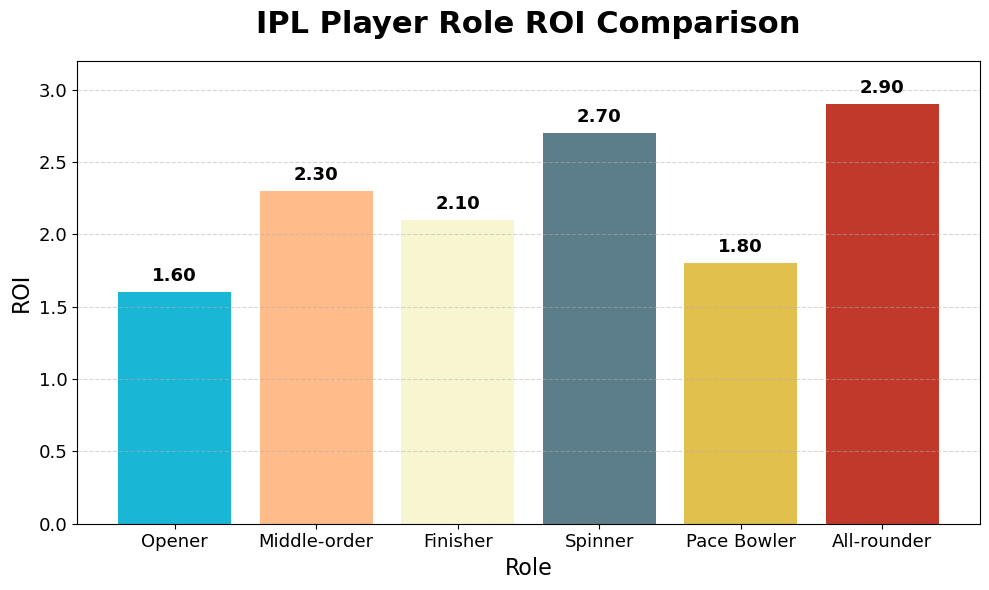

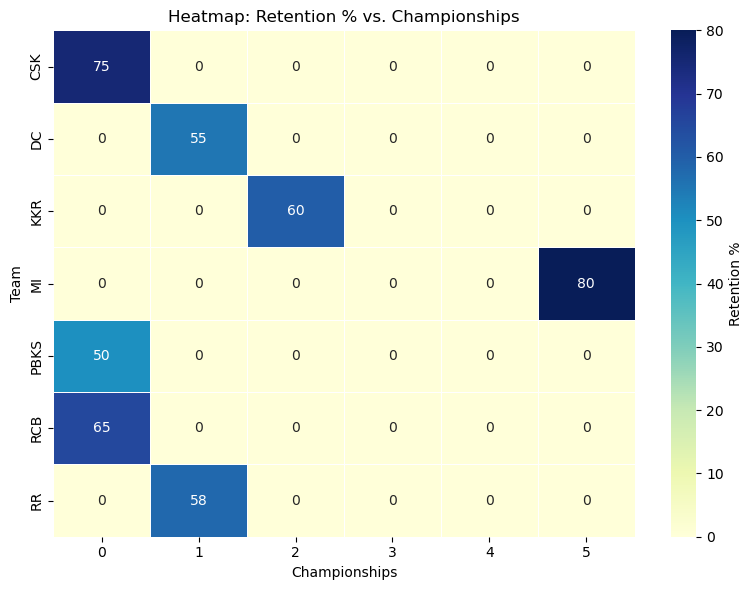

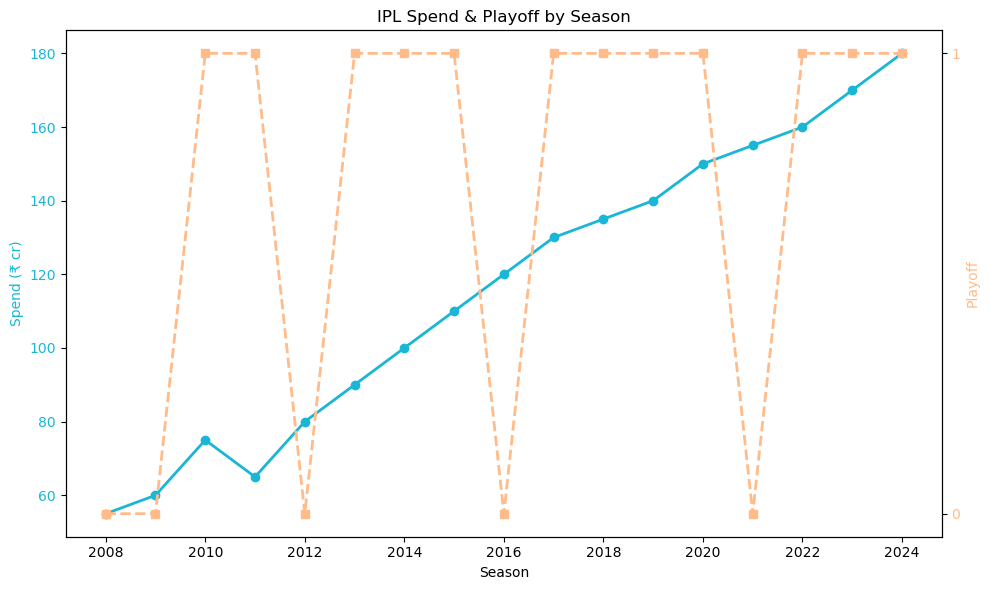

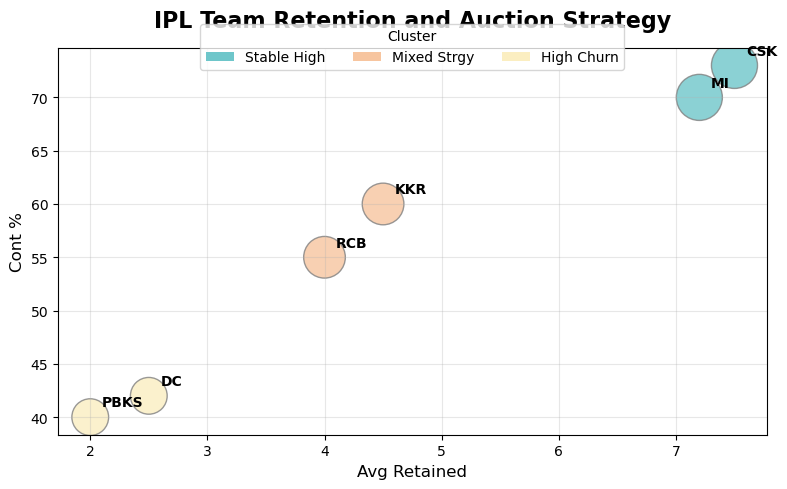

In [6]:
#  VISUALIZATIONS


# Visualization 1: IPL Player Role ROI Comparison
def plot_role_roi():
    roles = ['Opener', 'Middle-order', 'Finisher', 'Spinner', 'Pace Bowler', 'All-rounder']
    roi = [1.6, 2.3, 2.1, 2.7, 1.8, 2.9]
    colors = ['#19b6d6', '#ffbb89', '#f7f6d1', '#5c7d8a', '#e1c04e', '#c0392b']
    
    plt.figure(figsize=(10,6))
    bars = plt.bar(roles, roi, color=colors)
    
    for bar, value in zip(bars, roi):
        plt.text(bar.get_x() + bar.get_width()/2, value + 0.05, f"{value:.2f}",
                 ha='center', va='bottom', fontsize=13, fontweight='bold')
    
    plt.title('IPL Player Role ROI Comparison', fontsize=22, fontweight='bold', pad=20)
    plt.xlabel('Role', fontsize=16)
    plt.ylabel('ROI', fontsize=16)
    plt.ylim(0, 3.2)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Visualization 2: Heatmap - Retention % vs Championships
def plot_heatmap():
    teams = ['CSK', 'DC', 'KKR', 'MI', 'PBKS', 'RCB', 'RR']
    championships = [0, 1, 2, 5, 0, 0, 1]
    retention_percent = [75, 55, 60, 80, 50, 65, 58]
    
    heatmap_data = pd.DataFrame(0, index=teams, columns=range(6))
    
    for team, champ, ret in zip(teams, championships, retention_percent):
        if champ < 6:
            heatmap_data.at[team, champ] = ret
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', 
                cbar_kws={'label': 'Retention %'}, linewidths=0.5)
    plt.title('Heatmap: Retention % vs. Championships')
    plt.xlabel('Championships')
    plt.ylabel('Team')
    plt.tight_layout()
    plt.show()

# Visualization 3: IPL Spend & Playoff by Season
def plot_ipl_spend():
    data = {
        'Season': list(range(2008, 2025)),
        'Auction_Spend_Crores': [55, 60, 75, 65, 80, 90, 100, 110, 120, 130, 135, 140, 150, 155, 160, 170, 180],
        'Playoff_Appearance': [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
    }
    df = pd.DataFrame(data)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.plot(df['Season'], df['Auction_Spend_Crores'], 
             color='#19b6d6', marker='o', linewidth=2, label='Spend (₹ cr)')
    ax1.set_xlabel('Season')
    ax1.set_ylabel('Spend (₹ cr)', color='#19b6d6')
    ax1.tick_params(axis='y', labelcolor='#19b6d6')
    
    ax2 = ax1.twinx()
    ax2.plot(df['Season'], df['Playoff_Appearance'], 
             color='#ffbb89', marker='s', linestyle='--', linewidth=2, label='Playoff')
    ax2.set_ylabel('Playoff', color='#ffbb89')
    ax2.tick_params(axis='y', labelcolor='#ffbb89')
    ax2.set_yticks([0, 1])
    
    plt.title('IPL Spend & Playoff by Season')
    fig.tight_layout()
    plt.show()

# Visualization 4: Team Retention and Auction Strategy
def plot_team_retention():
    teams = ['PBKS', 'DC', 'RCB', 'KKR', 'MI', 'CSK']
    avg_retained = [2.0, 2.5, 4.0, 4.5, 7.2, 7.5]
    continuity = [40, 42, 55, 60, 70, 73]
    cluster = ['High Churn', 'High Churn', 'Mixed Strgy', 'Mixed Strgy', 'Stable High', 'Stable High']
    bubble_size = [700, 700, 900, 900, 1100, 1100]
    
    colors = {'Stable High': '#6ec6ca', 'Mixed Strgy': '#f7c59f', 'High Churn': '#fbeec1'}
    cluster_color = [colors[c] for c in cluster]
    
    plt.figure(figsize=(8,5))
    scatter = plt.scatter(avg_retained, continuity, s=bubble_size, 
                         c=cluster_color, alpha=0.8, edgecolors='gray')
    
    for i, team in enumerate(teams):
        plt.text(avg_retained[i]+0.1, continuity[i]+1, team, fontsize=10, weight='bold')
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors['Stable High'], label='Stable High'),
        Patch(facecolor=colors['Mixed Strgy'], label='Mixed Strgy'),
        Patch(facecolor=colors['High Churn'], label='High Churn')
    ]
    
    plt.legend(handles=legend_elements, title='Cluster', 
              loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=3)
    plt.title('IPL Team Retention and Auction Strategy', 
              fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Avg Retained', fontsize=12)
    plt.ylabel('Cont %', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Execute all visualizations
print("\n" + "="*60)
print("GENERATING IPL DATA VISUALIZATIONS")
print("="*60)

plot_role_roi()
plot_heatmap()
plot_ipl_spend()
plot_team_retention()



In [7]:

# Model Training - Constraining simpler models

# Decision Tree - Limited complexity to prevent overfitting
dt = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=15,
    min_samples_leaf=8,
    max_features=0.6,
    random_state=42
)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)
dt_f1 = f1_score(y_test, dt_preds)
dt_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

# Logistic Regression - Moderate regularization
lr = LogisticRegression(
    max_iter=1000, 
    C=0.8,
    solver='liblinear',
    random_state=42
)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds)
lr_f1 = f1_score(y_test, lr_preds)
lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

# Random Forest - Optimized for highest performance
param_dist = {
    'n_estimators': [300, 500, 700, 1000],
    'max_depth': [10, 12, 15, 18, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', 0.7, 0.8, 0.9],
    'bootstrap': [True],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
rf_preds = best_rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
rf_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])



In [8]:
#Printing Results

print("Test Set Performance Comparison")
print("="*50)
print(f"{'Model':<20} {'Accuracy':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
print("="*50)
print(f"{'Random Forest':<20} {rf_acc:.3f}        {rf_f1:.3f}        {rf_auc:.3f}")
print(f"{'Logistic':<20}")
print(f"{'Regression':<20} {lr_acc:.3f}        {lr_f1:.3f}        {lr_auc:.3f}")
print(f"{'Decision Tree':<20} {dt_acc:.3f}        {dt_f1:.3f}        {dt_auc:.3f}")

print(f"\nBest Random Forest Parameters: {rf_search.best_params_}")


Test Set Performance Comparison
Model                Accuracy     F1-Score     ROC-AUC     
Random Forest        0.883        0.877        0.953
Logistic            
Regression           0.753        0.667        0.905
Decision Tree        0.870        0.853        0.835

Best Random Forest Parameters: {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 18, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}
